In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and draw a graph
def generate_graph(num_nodes=3, num_edges=3, edges=None, random=False, highlight_edges=None):
    G = nx.Graph()
    if random:
        G = nx.gnm_random_graph(num_nodes, num_edges)
        edges = list(G.edges())
    else:
        if edges is None:
            raise ValueError("Edges must be provided if not generating a random graph")
        if min(min(edges)) == 1:
            edges = [(u - 1, v - 1) for u, v in edges]  # Convert 1-based to 0-based
        G.add_edges_from(edges)
        nodes = set()
        for edge in edges:
            nodes.update(edge)
        num_nodes = len(nodes)
    
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="grey")
    if highlight_edges:
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, edge_color='red', width=2)
    # plt.savefig(f"./graph/{var}.jpg")
    plt.show()
    # nx.write_gml(G, f"./graph/gml_{var}.gml")
    
    return G, num_nodes, edges


def node_color_to_index(node, color, k):
    index = (node) * k + (color - 1)
    return index

def create_Qmatrix(k, G, QUBO_panaliy):
    num_nodes = len(G.nodes)
    edges = list(G.edges)
    
    matrix_size = num_nodes * k
    Qmatrix = np.zeros((matrix_size, matrix_size))

    QUBO_panaliy = 4  # Penalty

    for i in range(num_nodes):
        submatrix = Qmatrix[i*k:(i+1)*k, i*k:(i+1)*k]
        for row in range(k):
            for col in range(k):
                if row == col:
                    submatrix[row, col] = -QUBO_panaliy
                else:
                    submatrix[row, col] = QUBO_panaliy
    for edge in edges:
        node1, node2 = edge
        for color in range(1, k + 1):
            index1 = node_color_to_index(node1, color, k)
            index2 = node_color_to_index(node2, color, k)
            Qmatrix[index1, index2] = QUBO_panaliy / 2
            Qmatrix[index2, index1] = QUBO_panaliy / 2

    return Qmatrix

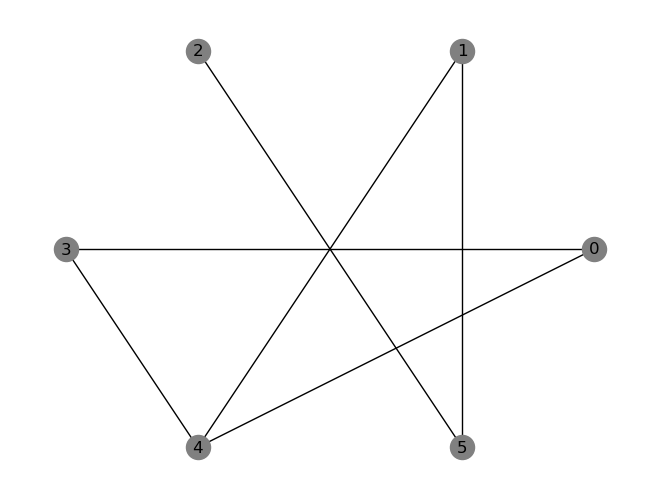

[[-4.  4.  4.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  0.  0.  0.  0.  0.]
 [ 4. -4.  4.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  0.  0.  0.  0.]
 [ 4.  4. -4.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  0. -4.  4.  4.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  4. -4.  4.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  0.]
 [ 0.  0.  0.  4.  4. -4.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0. -4.  4.  4.  0.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  4. -4.  4.  0.  0.  0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  4.  4. -4.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 2.  0.  0.  0.  0.  0.  0.  0.  0. -4.  4.  4.  2.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0.  4. -4.  4.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.  4.  4. -4.  0.  0.  2.  0.  0.  0.]
 [ 2.  0.  0.  2.  0.  0.  0.  0.  0.  2.  0.  0. -4.  4.  4.  0.  0.  0.]
 [ 0.  2.  0.  0.  2.  0.

In [8]:
# Fixed Graph
# example_edges = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (5, 2), (2, 4)]
# G, num_nodes, edges = generate_graph(edges=example_edges)

# Random Graph
num_nodes = 6
G, num_nodes, edges = generate_graph(num_nodes, 6, random=True)

Qmatrix = create_Qmatrix(3, G, 4)
print(Qmatrix)

In [9]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp

mdl = Model(name ="GC")
x = [mdl.binary_var('x%s' % i) for i in range (len(Qmatrix))]
objective = mdl.sum([x[i]* Qmatrix[i,j] * x[j] for i in range(len(Qmatrix)) for j in range(len(Qmatrix))])
mdl.minimize(objective)
qp = from_docplex_mp(mdl)

print(qp.prettyprint())

Problem name: GC

Minimize
  -4*x0^2 + 8*x0*x1 + 4*x0*x12 + 8*x0*x2 + 4*x0*x9 - 4*x1^2 + 4*x1*x10
  + 4*x1*x13 + 8*x1*x2 - 4*x10^2 + 8*x10*x11 + 4*x10*x13 - 4*x11^2 + 4*x11*x14
  - 4*x12^2 + 8*x12*x13 + 8*x12*x14 - 4*x13^2 + 8*x13*x14 - 4*x14^2 - 4*x15^2
  + 8*x15*x16 + 8*x15*x17 - 4*x16^2 + 8*x16*x17 - 4*x17^2 + 4*x2*x11 + 4*x2*x14
  - 4*x2^2 + 4*x3*x12 + 4*x3*x15 - 4*x3^2 + 8*x3*x4 + 8*x3*x5 + 4*x4*x13
  + 4*x4*x16 - 4*x4^2 + 8*x4*x5 + 4*x5*x14 + 4*x5*x17 - 4*x5^2 + 4*x6*x15
  - 4*x6^2 + 8*x6*x7 + 8*x6*x8 + 4*x7*x16 - 4*x7^2 + 8*x7*x8 + 4*x8*x17 - 4*x8^2
  + 8*x9*x10 + 8*x9*x11 + 4*x9*x12 - 4*x9^2

Subject to
  No constraints

  Binary variables (18)
    x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12 x13 x14 x15 x16 x17



In [10]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 18.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIZII', 'IIIIIIIIZIIIIIIIIZ', 'IIIIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIIIIZ', 'IIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZZI', 'IIIIIIIZIIIIIIIIZI', 'IIIIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIIIZI', 'IIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIZII', 'IIIIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIIZII', 'IIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIZIZIII', 'IIIIIIIIIIIIZIIIII', 'IIIIIZIIIIIIIIZIII', 'IIZIIIIIIIIIIIZIII', 'IIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZZIIII', 'IIIIZIIIIIIIIZIIII', 'IZIIIIIIIIIIIZIIII', 'IZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIZIIIII', 'ZIIIIIIIIIIIZIIIII', 'ZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIII', 'IIIIIIIIIIZZIIIIII', 'IIIIIIIIIIZIIIIIII', 'IIIIIIIIIZIZIIIIII', 'IIIIIIIIIZIIIIIIII', 'IIZIIIIIIIIZIIIIII', 'IIIIIIIIIZZIIIIIII', 'IZIIIIIIIIZIIIIIII', 'ZIIIIIIIIZIIIIIIII', 'IIIIIIIZZIIIIIIIII', 'IIIIII

In [11]:
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from typing import List, Tuple


algorithm_globals.random_seed = 2024

qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [12]:
qaoa_result = qaoa.solve(qp)
print("qaoa_result: ", qaoa_result.prettyprint())
exact_result = exact.solve(qp)
print("exact_result: ", exact_result.prettyprint())

# print("variable order:", [var.name for var in qaoa_result.variables])
# for s in qaoa_result.samples:
#     print(s)

qaoa_result:  objective function value: -24.0
variable values: x0=0.0, x1=0.0, x2=1.0, x3=0.0, x4=1.0, x5=0.0, x6=0.0, x7=1.0, x8=0.0, x9=0.0, x10=1.0, x11=0.0, x12=1.0, x13=0.0, x14=0.0, x15=1.0, x16=0.0, x17=0.0
status: SUCCESS
exact_result:  objective function value: -24.0
variable values: x0=0.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=0.0, x7=1.0, x8=0.0, x9=0.0, x10=1.0, x11=0.0, x12=1.0, x13=0.0, x14=0.0, x15=1.0, x16=0.0, x17=0.0
status: SUCCESS


In [13]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.fval == threshold:
            res.append(s)

    return res

filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=qaoa_result.fval, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0.]), fval=-24.0, probability=3.8146972656e-06, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0.]), fval=-24.0, probability=3.8146972656e-06, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0.]), fval=-24.0, probability=3.8146972656e-06, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       0.]), fval=-24.0, probability=3.8146972656e-06, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0.]), fval=-24.0, probability=3.8146972656e-06, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0.,

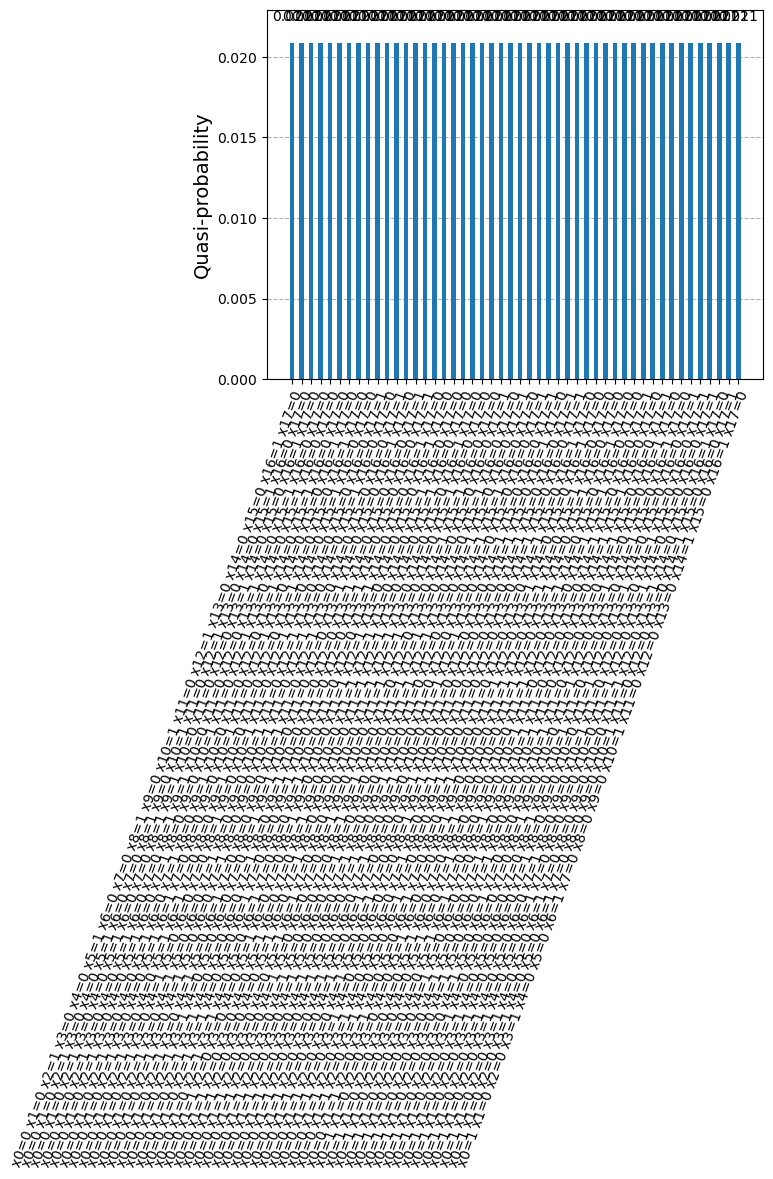

In [14]:
samples_for_plot = {
    " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}

# print(samples_for_plot)

plot_histogram(samples_for_plot)

In [15]:
def solution_to_color_dict(solution, num_nodes, k):
    color_dict = {}
    for node in range(num_nodes):
        for color in range(k):
            if solution[node * k + color] == 1:
                color_dict[node] = color + 1
                break

    print("Coloring dictionary:",color_dict)
    return color_dict

def valid_results(num_nodes, k, graph, coloring):
    if len(coloring) < num_nodes: #The node with all 0s in its corresponding qpu solution is missing in the result color dictionary, which needs to be assigned an extra color.
        print("Because of result error, one extra color will be added. k =", k+1)
        coloring = check_and_fill_missing_nodes(num_nodes, coloring, k+1)
    is_valid = validate_graph_coloring(graph, coloring)
    print("Is coloring valid? -", is_valid)
    is_minimum_coloring(graph, coloring)

def check_and_fill_missing_nodes(num_nodes, color_dict, fill_color):
    
    for key in range(num_nodes):
        if key not in color_dict:
            color_dict[key] = fill_color
            print("Error in:", key)
        
    return color_dict

def validate_graph_coloring(graph, coloring):
    for u, v in graph.edges():
        if coloring[u] == coloring[v]:
            return False  
        
        return True 


def get_approx_chromatic_number(graph):
    coloring = nx.greedy_color(graph, strategy="largest_first")
    used_colors = set(coloring.values())
    return len(used_colors)

def is_minimum_coloring(graph, coloring):
    approx_chromatic_number = get_approx_chromatic_number(graph)
    used_colors = set(coloring.values())
    if len(used_colors) == approx_chromatic_number:
        print("Is the coloring using minimum number of colors? -", True)
    else:
        print("Is the coloring using minimum number of colors? -", False)
        print("Minimum number of colors(approx_chromatic_number):", approx_chromatic_number, "Number of colors used:", len(used_colors))


In [16]:
color_dict = solution_to_color_dict(list(filtered_samples[0].x), num_nodes, 3)
valid_results(num_nodes, 3, G, color_dict)

Coloring dictionary: {0: 3, 1: 2, 2: 2, 3: 2, 4: 1, 5: 1}
Is coloring valid? - True
Is the coloring using minimum number of colors? - True


In [50]:
num_nodes

6